In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Cruzamento e enriquecimento dos dados

In [3]:

product_df = pd.read_csv('data_samples/product.csv')
sales_df = pd.read_csv('data_samples/sales.csv')
print("Dados carregados!")

merged_df = sales_df.merge(product_df, on='ProductKey', how='inner')

merged_df['TotalCost'] = merged_df['UnitCost'] * merged_df['Quantity']
merged_df['Profit'] = merged_df['NetPrice'] - merged_df['TotalCost'] 
merged_df['MarginPercent'] = (merged_df['Profit'] / merged_df['NetPrice']) * 100
print(f"Dados mesclados: {len(merged_df)} registros")

Dados carregados!
Dados mesclados: 3996 registros


### Top10 maiores receitas por produto

In [8]:
produtos_receita = merged_df.groupby(['ProductKey', 'ProductName'])\
                .agg({'NetPrice': 'sum', 'Quantity': 'sum', 'Profit': 'sum'})\
                .reset_index()\
                .sort_values('NetPrice', ascending=False)\
                .head(10)

produtos_receita

,ProductKey,ProductName,NetPrice,Quantity,Profit
276,416,Adventure Works Desktop PC2.33 XD233 Silver,22708.515,52,-7149.135
293,433,Adventure Works Desktop PC2.33 XD233 White,18081.540,24,4115.865
420,612,WWI Projector 1080p DLP86 Black,17093.160,16,-5676.015
310,450,WWI Desktop PC2.33 X2330 Brown,16762.560,35,-3485.360
387,551,Proseware Projector 1080p LCD86 White,15720.750,19,-12793.500
298,438,WWI Desktop PC2.33 X2330 Silver,15186.475,26,1180.395
288,428,Adventure Works Desktop PC2.33 XD233 Brown,15000.120,28,-1212.905
299,439,WWI Desktop PC2.30 M2300 Brown,12778.740,36,-4058.690
413,599,Contoso Projector 1080p X980 Silver,12393.000,10,-2814.600
305,445,WWI Desktop PC2.30 M2300 Black,12049.245,31,-3502.885


In [9]:
produtos_qtd = merged_df.groupby(['ProductKey', 'ProductName', 'CategoryName'])\
                .agg({'Quantity': 'sum', 'NetPrice': 'sum', 'Profit': 'sum'})\
                .reset_index()\
                .sort_values('Quantity', ascending=False)\
                .head(10)
produtos_qtd

,ProductKey,ProductName,CategoryName,Quantity,NetPrice,Profit
303,443,WWI Desktop PC3.0 M0300 Silver,Computers,78,11302.36500,-12289.66500
1169,1690,SV Hand Games for Office worker L28 Yellow,Games and Toys,67,249.09039,-90.39861
1162,1683,MGS Hand Games for 12-16 boys E600 Silver,Games and Toys,56,52.67943,-75.33657
276,416,Adventure Works Desktop PC2.33 XD233 Silver,Computers,52,22708.51500,-7149.13500
307,447,WWI Desktop PC1.80 E1800 Black,Computers,49,5111.82650,-5964.51850
318,458,WWI Desktop PC1.80 E1800 White,Computers,47,3578.39350,-5739.80150
1068,1589,SV DVD 38 DVD Storage Binder E25 Silver,"Music, Movies and Audio Books",46,146.37348,-129.50452
1119,1640,Contoso DVD 60 DVD Storage Binder L20 Red,"Music, Movies and Audio Books",45,288.50556,-66.99644
1175,1696,SV Hand Games for Office worker L28 Black,Games and Toys,45,158.10894,-69.90606
1139,1660,Contoso DVD 15-Inch Player Portable L200 White,"Music, Movies and Audio Books",43,3446.82114,-809.52286


In [13]:
status_categorias = merged_df.groupby('CategoryName')\
                         .agg({
                             'NetPrice': ['sum', 'mean'],
                             'Quantity': 'sum',
                             'Profit': ['sum', 'mean'],
                             'MarginPercent': 'mean',
                             'ProductKey': 'nunique'
                         }).round(2)

status_categorias.columns = ['_'.join(col).strip() for col in status_categorias.columns]

perf_categ = status_categorias.reset_index()

perf_categ

,CategoryName,NetPrice_sum,NetPrice_mean,Quantity_sum,Profit_sum,Profit_mean,MarginPercent_mean,ProductKey_nunique
0,Audio,43729.90,103.14,1302,-14986.31,-35.35,-46.88,103
1,Cameras and camcorders,156490.53,431.10,1067,-33006.31,-90.93,-36.65,241
2,Cell phones,217912.88,291.72,2303,-93718.72,-125.46,-49.22,252
3,Computers,725160.40,765.74,3036,-314015.88,-331.59,-55.10,373
4,Games and Toys,13494.27,24.67,1813,-7741.12,-14.15,-66.44,148
5,Home Appliances,107227.44,423.82,788,-43707.63,-172.76,-55.30,175
6,"Music, Movies and Audio Books",56776.29,109.61,1586,-11823.68,-22.83,-37.12,90
7,TV and Video,71727.34,364.10,639,-32510.57,-165.03,-60.12,111


### Análise do Período de Compras

In [14]:
df = merged_df.copy()
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

monthly_sales = (
    df.groupby([
        df['OrderDate'].dt.year.rename('Year'),
        df['OrderDate'].dt.month.rename('Month')
    ])\
    .agg(NetPrice=('NetPrice', 'sum'),
            Quantity=('Quantity', 'sum'),
            NumOrders=('OrderKey', 'count'))\
    .reset_index()
)

dow_sales = (
    df.groupby(df['OrderDate'].dt.day_name().rename('Weekday'))\
    .agg(NetPrice=('NetPrice', 'sum'),
            Quantity=('Quantity', 'sum'),
            NumOrders=('OrderKey', 'count'))\
    .reset_index()
)

### Gráficos - Análise do Período de Compras

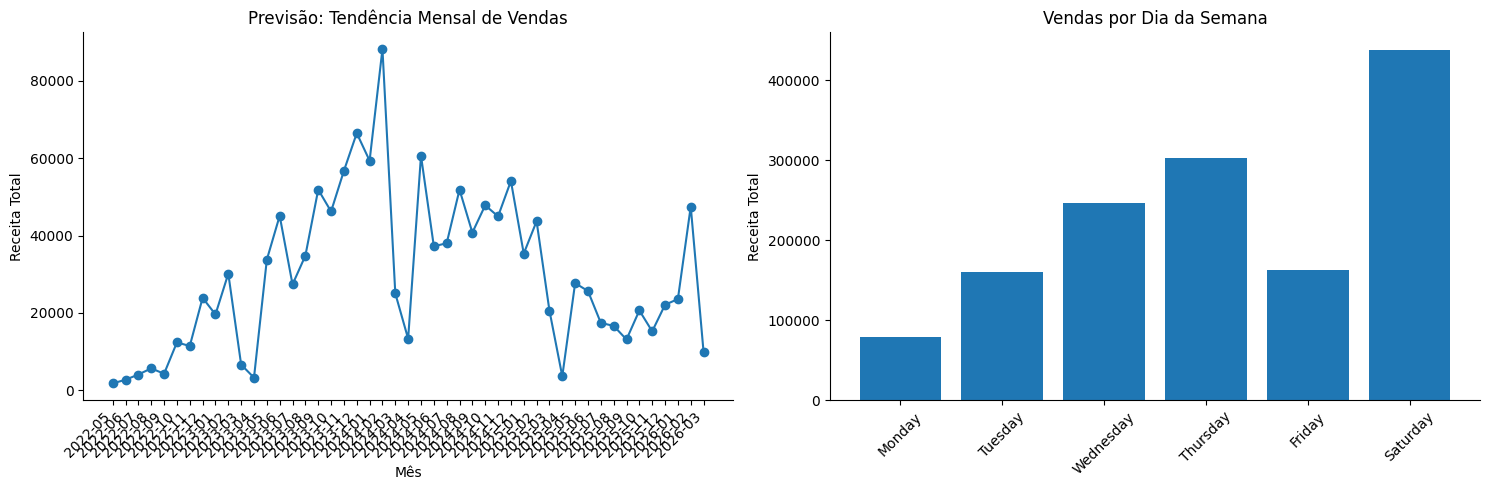

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


labels = monthly_sales['Year'].astype(int).astype(str) + '-' + monthly_sales['Month'].astype(int).astype(str).str.zfill(2)
ax1.plot(range(len(monthly_sales)), monthly_sales['NetPrice'], marker='o')
ax1.set_title('Previsão: Tendência Mensal de Vendas')
ax1.set_xlabel('Mês')
ax1.set_ylabel('Receita Total')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')


dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
available = [d for d in dow_order if d in list(dow_sales['Weekday'])]
if available:
    dow_sales = dow_sales.set_index('Weekday').reindex(available).reset_index()

ax2.bar(dow_sales['Weekday'], dow_sales['NetPrice'])
ax2.set_title('Vendas por Dia da Semana')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Receita Total')

plt.tight_layout()
plt.show()